In [ ]:
import torch
import torchvision
import  torchvision.transforms as transforms

In [ ]:
#load pretrained resnet model
model = torchvision.models.vgg16(pretrained=True)
print(model)

#define transforms to preprocess input image into format expected by model
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

#transforms to resize image to the size expected by pretrained model,
#convert PIL image to tensor, and
#normalize the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,          
])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max (torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image#
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().numpy(), (1, 2, 0)))
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.binary_r)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

img = mpimg.imread('/content/17.jpg')
img.shape
#saliency(img, model)

(347, 500, 3)

In [ ]:
from operator import add
from functools import reduce

def split4(image):
    half_split = np.array_split(image, 2)
    res = map(lambda x: np.array_split(x, 2, axis=1), half_split)
    return reduce(add, res)

split_img = split4(img)
split_img[0].shape

(174, 250, 3)

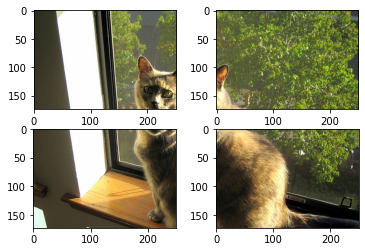

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(split_img[0])
axs[0, 1].imshow(split_img[1])
axs[1, 0].imshow(split_img[2])
axs[1, 1].imshow(split_img[3])

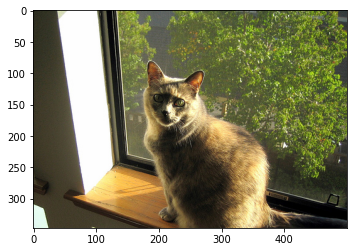

In [ ]:
def concatenate4(north_west, north_east, south_west, south_east):
    top = np.concatenate((north_west, north_east), axis=1)
    bottom = np.concatenate((south_west, south_east), axis=1)
    return np.concatenate((top, bottom), axis=0)

full_img = concatenate4(split_img[0], split_img[1], split_img[2], split_img[3])
plt.imshow(full_img)
plt.show()

[[[133 132 109]
  [103 114  55]]

 [[124 109  81]
  [ 98  89  55]]]


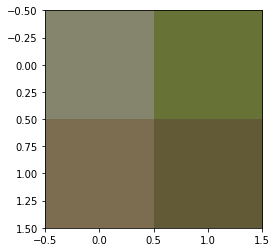

In [ ]:
def calculate_mean(img):
    return np.mean(img, axis=(0, 1))

means = np.array(list(map(lambda x: calculate_mean(x), split_img))).astype(int).reshape(2,2,3)
print(means)
plt.imshow(means)
plt.show()

In [ ]:
def checkEqual(myList):
    first=myList[0]
    return all((x==first).all() for x in myList)

class QuadTree:
    
    def insert(self, img, level = 0):
        self.level = level
        self.mean = calculate_mean(img).astype(int)
        self.resolution = (img.shape[0], img.shape[1])
        self.final = True
        
        #for i in range(3):
          #while calculate_mean(img[i] <=100):
        if not checkEqual(img):
          split_img = split4(img)
            
          self.final = False
          self.north_west = QuadTree().insert(split_img[0], level + 1)
          self.north_east = QuadTree().insert(split_img[1], level + 1)
          self.south_west = QuadTree().insert(split_img[2], level + 1)
          self.south_east = QuadTree().insert(split_img[3], level + 1)

        return self
    
    def get_image(self, level):
        if(self.final or self.level == level):
            return np.tile(self.mean, (self.resolution[0], self.resolution[1], 1))
        
        return concatenate4(
            self.north_west.get_image(level), 
            self.north_east.get_image(level),
            self.south_west.get_image(level),
            self.south_east.get_image(level))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


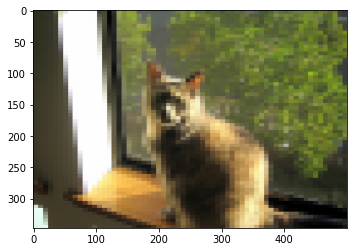

In [ ]:
quadtree = QuadTree().insert(img)
plt.imshow(quadtree.get_image(6))
plt.show()

In [ ]:
quadtree = QuadTree().insert(img)
img1 = quadtree.get_image(7)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [ ]:
from PIL import Image
import numpy as np

img_pil1 = Image.fromarray(np.uint8(img1)).convert('RGB')

In [ ]:
from PIL import Image
import numpy as np

img_pil = Image.fromarray(np.uint8(img)).convert('RGB')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


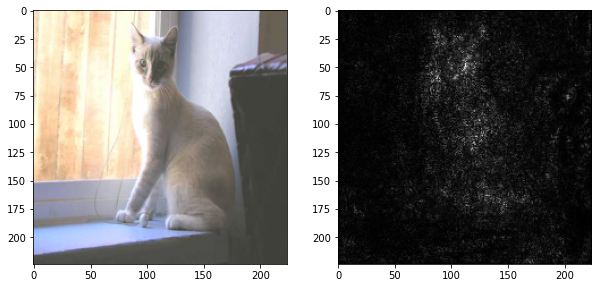

In [ ]:
saliency(img_pil, model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


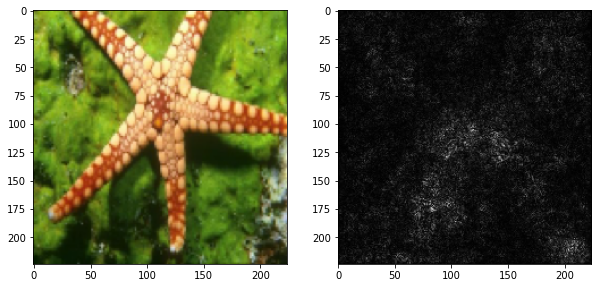

In [ ]:
saliency(img_pil1, model)